#### Libraries Imported and Setup

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 3090


#### Model Architecture

##### Vision Transformer Model

In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :- 
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)
    
    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [10]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [11]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [12]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [13]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [14]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [15]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [16]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [17]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation Functions

In [19]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 256
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 10
layers = 12
channels = 3
resnet_features_channels = 64
heads = 16
epochs = 100

In [20]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence 
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [21]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)
    
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 3
- heads = 16

In [22]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

In [23]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15994634

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

In [ ]:
# Hybrid Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

16494346

##### Model - ResNet50 or ResNet34

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet34 Architecture

model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet50 Architecture

model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

#### Model Training and Evaluation

##### CIFAR10 Dataset

In [25]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:47<00:00,  4.09it/s]


Epoch : 1 - acc: 0.3052 - loss : 1.8734



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.56it/s]


test acc: 0.3732 - test loss : 1.7129



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 2 - acc: 0.3621 - loss : 1.7309



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.88it/s]


test acc: 0.4023 - test loss : 1.6411



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.07it/s]


Epoch : 5 - acc: 0.4315 - loss : 1.5637



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.56it/s]


test acc: 0.4572 - test loss : 1.5130



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.07it/s]


Epoch : 6 - acc: 0.4421 - loss : 1.5308



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.65it/s]


test acc: 0.4771 - test loss : 1.4490



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 7 - acc: 0.4572 - loss : 1.4980



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.90it/s]


test acc: 0.4780 - test loss : 1.4519



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.04it/s]


Epoch : 8 - acc: 0.4684 - loss : 1.4677



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.57it/s]


test acc: 0.4864 - test loss : 1.4206



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 9 - acc: 0.4775 - loss : 1.4433



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.40it/s]


test acc: 0.4748 - test loss : 1.4568



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 10 - acc: 0.4888 - loss : 1.4186



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.78it/s]


test acc: 0.4938 - test loss : 1.4063



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 11 - acc: 0.4966 - loss : 1.3969



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.51it/s]


test acc: 0.5024 - test loss : 1.3764



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.07it/s]


Epoch : 12 - acc: 0.5004 - loss : 1.3883



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.51it/s]


test acc: 0.5166 - test loss : 1.3316



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 13 - acc: 0.5106 - loss : 1.3637



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.74it/s]


test acc: 0.5101 - test loss : 1.3758



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 14 - acc: 0.5148 - loss : 1.3503



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.66it/s]


test acc: 0.5097 - test loss : 1.3787



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.04it/s]


Epoch : 15 - acc: 0.5236 - loss : 1.3296



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.66it/s]


test acc: 0.5277 - test loss : 1.3128



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 16 - acc: 0.5251 - loss : 1.3155



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.72it/s]


test acc: 0.5271 - test loss : 1.3231



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.07it/s]


Epoch : 17 - acc: 0.5304 - loss : 1.2994



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.72it/s]


test acc: 0.5213 - test loss : 1.3578



 70%|████████████████████████████▋            | 137/196 [00:33<00:14,  3.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 37 - acc: 0.6019 - loss : 1.1119



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.55it/s]


test acc: 0.5706 - test loss : 1.2082



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 38 - acc: 0.6077 - loss : 1.0982



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.65it/s]


test acc: 0.5548 - test loss : 1.2793



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 41 - acc: 0.6167 - loss : 1.0796



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.49it/s]


test acc: 0.5791 - test loss : 1.1869



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 42 - acc: 0.6159 - loss : 1.0815



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.75it/s]


test acc: 0.5759 - test loss : 1.1895



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 43 - acc: 0.6179 - loss : 1.0753



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.61it/s]


test acc: 0.5649 - test loss : 1.2167



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 44 - acc: 0.6198 - loss : 1.0706



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.72it/s]


test acc: 0.5841 - test loss : 1.1687



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.07it/s]


Epoch : 45 - acc: 0.6225 - loss : 1.0624



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.55it/s]


test acc: 0.5864 - test loss : 1.1855



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.04it/s]


Epoch : 46 - acc: 0.6282 - loss : 1.0501



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.60it/s]


test acc: 0.5841 - test loss : 1.1770



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 47 - acc: 0.6272 - loss : 1.0496



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.72it/s]


test acc: 0.5878 - test loss : 1.1747



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 48 - acc: 0.6327 - loss : 1.0403



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.50it/s]


test acc: 0.5812 - test loss : 1.1858



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 49 - acc: 0.6333 - loss : 1.0333



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.65it/s]


test acc: 0.5771 - test loss : 1.1955



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 50 - acc: 0.6338 - loss : 1.0318



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.77it/s]


test acc: 0.5852 - test loss : 1.1948



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.04it/s]


Epoch : 51 - acc: 0.6362 - loss : 1.0204



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.50it/s]


test acc: 0.5850 - test loss : 1.1896



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 52 - acc: 0.6375 - loss : 1.0217



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.60it/s]


test acc: 0.5954 - test loss : 1.1686



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 53 - acc: 0.6408 - loss : 1.0151



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.67it/s]


test acc: 0.5979 - test loss : 1.1475



 75%|██████████████████████████████▊          | 147/196 [00:36<00:12,  4.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.72it/s]


test acc: 0.6080 - test loss : 1.1463



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 86 - acc: 0.6955 - loss : 0.8635



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.44it/s]


test acc: 0.6157 - test loss : 1.1413



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.04it/s]


Epoch : 87 - acc: 0.6943 - loss : 0.8556



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.53it/s]


test acc: 0.6185 - test loss : 1.1425



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 88 - acc: 0.6977 - loss : 0.8547



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.56it/s]


test acc: 0.6197 - test loss : 1.1402



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 89 - acc: 0.6967 - loss : 0.8516



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.57it/s]


test acc: 0.6160 - test loss : 1.1282



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 92 - acc: 0.7011 - loss : 0.8399



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.81it/s]


test acc: 0.6118 - test loss : 1.1531



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.04it/s]


Epoch : 93 - acc: 0.7028 - loss : 0.8327



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.44it/s]


test acc: 0.6117 - test loss : 1.1537



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.04it/s]


Epoch : 94 - acc: 0.7035 - loss : 0.8350



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.70it/s]


test acc: 0.6140 - test loss : 1.1533



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 95 - acc: 0.7065 - loss : 0.8287



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.71it/s]


test acc: 0.6086 - test loss : 1.1941



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 96 - acc: 0.7028 - loss : 0.8309



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.57it/s]


test acc: 0.6332 - test loss : 1.0815



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.05it/s]


Epoch : 97 - acc: 0.7080 - loss : 0.8247



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.62it/s]


test acc: 0.6239 - test loss : 1.1108



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 98 - acc: 0.7091 - loss : 0.8187



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.94it/s]


test acc: 0.6235 - test loss : 1.0993



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 99 - acc: 0.7082 - loss : 0.8162



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.61it/s]


test acc: 0.6202 - test loss : 1.1284



100%|█████████████████████████████████████████| 196/196 [00:48<00:00,  4.06it/s]


Epoch : 100 - acc: 0.7142 - loss : 0.8099



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.67it/s]


test acc: 0.6063 - test loss : 1.1607



In [26]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15994634

##### CIFAR100 Dataset

In [23]:
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoints/' + model.name + '_CIFAR100_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:30<00:00,  6.42it/s]


Epoch : 1 - acc: 0.0626 - loss : 4.2460



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.87it/s]


test acc: 0.0948 - test loss : 3.9629



100%|█████████████████████████████████████████| 196/196 [00:30<00:00,  6.34it/s]


Epoch : 2 - acc: 0.1082 - loss : 3.8795



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.72it/s]


test acc: 0.1327 - test loss : 3.7303



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.31it/s]


Epoch : 3 - acc: 0.1386 - loss : 3.6736



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.60it/s]


test acc: 0.1562 - test loss : 3.5662



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch : 4 - acc: 0.1606 - loss : 3.5329



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.54it/s]


test acc: 0.1838 - test loss : 3.4055



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.19it/s]


Epoch : 5 - acc: 0.1854 - loss : 3.3972



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.57it/s]


test acc: 0.2122 - test loss : 3.2768



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch : 6 - acc: 0.2030 - loss : 3.2956



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.48it/s]


test acc: 0.2253 - test loss : 3.2214



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch : 7 - acc: 0.2156 - loss : 3.2102



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.70it/s]


test acc: 0.2318 - test loss : 3.1509



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.30it/s]


Epoch : 8 - acc: 0.2302 - loss : 3.1357



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.67it/s]


test acc: 0.2545 - test loss : 3.0667



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.30it/s]


Epoch : 9 - acc: 0.2425 - loss : 3.0684



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.66it/s]


test acc: 0.2608 - test loss : 3.0293



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.30it/s]


Epoch : 10 - acc: 0.2551 - loss : 2.9997



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.70it/s]


test acc: 0.2723 - test loss : 2.9393



100%|█████████████████████████████████████████| 196/196 [00:31<00:00,  6.29it/s]


Epoch : 11 - acc: 0.2653 - loss : 2.9467



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.59it/s]


test acc: 0.2808 - test loss : 2.9162



100%|█████████████████████████████████████████| 196/196 [00:34<00:00,  5.76it/s]


Epoch : 12 - acc: 0.2754 - loss : 2.8892



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.2843 - test loss : 2.8852



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 13 - acc: 0.2848 - loss : 2.8509



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


test acc: 0.2835 - test loss : 2.8605



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 14 - acc: 0.2950 - loss : 2.8002



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.2978 - test loss : 2.8264



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 15 - acc: 0.3012 - loss : 2.7558



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.69it/s]


test acc: 0.3052 - test loss : 2.7874



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 16 - acc: 0.3123 - loss : 2.7064



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.3111 - test loss : 2.7830



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 17 - acc: 0.3204 - loss : 2.6686



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.3164 - test loss : 2.7574



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 18 - acc: 0.3267 - loss : 2.6356



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.3232 - test loss : 2.7156



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 19 - acc: 0.3321 - loss : 2.5982



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.3295 - test loss : 2.6948



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 20 - acc: 0.3433 - loss : 2.5530



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.95it/s]


test acc: 0.3325 - test loss : 2.6660



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 21 - acc: 0.3513 - loss : 2.5176



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.3376 - test loss : 2.6485



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 22 - acc: 0.3585 - loss : 2.4839



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.3413 - test loss : 2.6128



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 23 - acc: 0.3641 - loss : 2.4566



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.3478 - test loss : 2.6061



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 24 - acc: 0.3675 - loss : 2.4215



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.3546 - test loss : 2.6018



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 25 - acc: 0.3772 - loss : 2.3906



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.3492 - test loss : 2.5819



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.51it/s]


Epoch : 26 - acc: 0.3837 - loss : 2.3573



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.3572 - test loss : 2.5600



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 27 - acc: 0.3915 - loss : 2.3289



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.3581 - test loss : 2.5509



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 28 - acc: 0.3963 - loss : 2.2893



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.3588 - test loss : 2.5580



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 29 - acc: 0.4064 - loss : 2.2544



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.88it/s]


test acc: 0.3664 - test loss : 2.5323



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.51it/s]


Epoch : 30 - acc: 0.4124 - loss : 2.2267



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.3656 - test loss : 2.5279



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 31 - acc: 0.4169 - loss : 2.1997



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.3650 - test loss : 2.5395



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 32 - acc: 0.4233 - loss : 2.1697



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.3783 - test loss : 2.5016



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 33 - acc: 0.4319 - loss : 2.1368



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.3737 - test loss : 2.5031



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 34 - acc: 0.4340 - loss : 2.1129



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.3743 - test loss : 2.4848



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 35 - acc: 0.4418 - loss : 2.0872



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


test acc: 0.3812 - test loss : 2.4838



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 36 - acc: 0.4487 - loss : 2.0573



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.3742 - test loss : 2.5029



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 37 - acc: 0.4569 - loss : 2.0211



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.3879 - test loss : 2.4835



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 38 - acc: 0.4647 - loss : 1.9864



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.00it/s]


test acc: 0.3894 - test loss : 2.4677



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 39 - acc: 0.4679 - loss : 1.9712



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


test acc: 0.3945 - test loss : 2.4398



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 40 - acc: 0.4739 - loss : 1.9453



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.3891 - test loss : 2.4656



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 41 - acc: 0.4798 - loss : 1.9158



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.3863 - test loss : 2.4928



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 42 - acc: 0.4866 - loss : 1.8828



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.3921 - test loss : 2.4493



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 43 - acc: 0.4922 - loss : 1.8481



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.70it/s]


test acc: 0.3966 - test loss : 2.4585



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 44 - acc: 0.4977 - loss : 1.8218



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.70it/s]


test acc: 0.4023 - test loss : 2.4531



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 45 - acc: 0.5071 - loss : 1.7958



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.3960 - test loss : 2.4685



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 46 - acc: 0.5151 - loss : 1.7601



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.3952 - test loss : 2.4613



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 47 - acc: 0.5198 - loss : 1.7406



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.96it/s]


test acc: 0.4078 - test loss : 2.4290



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 48 - acc: 0.5279 - loss : 1.7036



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.99it/s]


test acc: 0.3997 - test loss : 2.4444



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 49 - acc: 0.5312 - loss : 1.6831



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.3954 - test loss : 2.4537



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 50 - acc: 0.5381 - loss : 1.6469



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.4054 - test loss : 2.4690



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 51 - acc: 0.5447 - loss : 1.6258



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.4101 - test loss : 2.4676



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 52 - acc: 0.5540 - loss : 1.6004



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


test acc: 0.4117 - test loss : 2.4518



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 54 - acc: 0.5660 - loss : 1.5309



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.4017 - test loss : 2.4994



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 55 - acc: 0.5751 - loss : 1.5047



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.4039 - test loss : 2.4922



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 56 - acc: 0.5813 - loss : 1.4784



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.92it/s]


test acc: 0.4105 - test loss : 2.4824



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 57 - acc: 0.5853 - loss : 1.4479



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.98it/s]


test acc: 0.4072 - test loss : 2.4826



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 58 - acc: 0.5971 - loss : 1.4152



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.4095 - test loss : 2.4985



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 59 - acc: 0.6021 - loss : 1.3855



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.4102 - test loss : 2.5120



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 60 - acc: 0.6083 - loss : 1.3655



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.4114 - test loss : 2.5061



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 61 - acc: 0.6182 - loss : 1.3241



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.4070 - test loss : 2.5610



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 62 - acc: 0.6239 - loss : 1.2937



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.4105 - test loss : 2.5494



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 63 - acc: 0.6315 - loss : 1.2627



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.4109 - test loss : 2.5684



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 64 - acc: 0.6379 - loss : 1.2370



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.4097 - test loss : 2.5865



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 65 - acc: 0.6470 - loss : 1.2061



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.86it/s]


test acc: 0.4171 - test loss : 2.5994



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.50it/s]


Epoch : 66 - acc: 0.6546 - loss : 1.1798



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.18it/s]


test acc: 0.4068 - test loss : 2.6427



  7%|███                                       | 14/196 [00:05<01:11,  2.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 91 - acc: 0.8290 - loss : 0.5442



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.4204 - test loss : 3.1676



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 92 - acc: 0.8361 - loss : 0.5170



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.4188 - test loss : 3.1850



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 93 - acc: 0.8410 - loss : 0.5076



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.14it/s]


test acc: 0.4159 - test loss : 3.2036



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 94 - acc: 0.8474 - loss : 0.4830



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


test acc: 0.4176 - test loss : 3.2338



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 95 - acc: 0.8523 - loss : 0.4653



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.4153 - test loss : 3.2374



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 96 - acc: 0.8540 - loss : 0.4551



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.4150 - test loss : 3.3198



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 97 - acc: 0.8613 - loss : 0.4359



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.4181 - test loss : 3.3205



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 98 - acc: 0.8617 - loss : 0.4313



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.4198 - test loss : 3.3258



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 99 - acc: 0.8683 - loss : 0.4139



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.73it/s]


test acc: 0.4181 - test loss : 3.3337



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 100 - acc: 0.8737 - loss : 0.3982



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.4209 - test loss : 3.3295



In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

16017764

##### Saving accuracy

In [27]:
import csv

dataset = 'cifar10'
path = './results/'
model_name = 'original'

with open(path+'train_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in train_accs:
        wr.writerow([point])
        
        
with open(path+'test_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in test_accs:
        wr.writerow([point])

##### Plotting Results

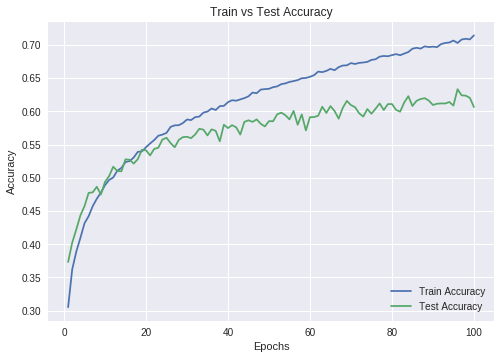

In [28]:
#CIFAR10
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

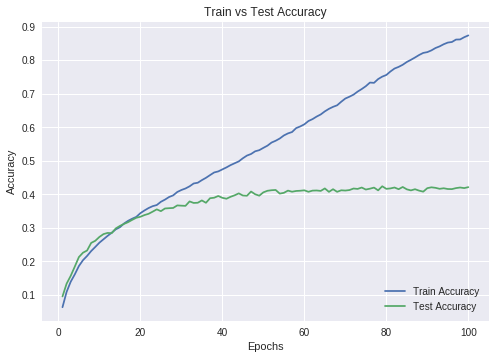

In [25]:
#CIFAR100
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')